# Case 1. Heart Disease Classification

#### Joonas Lehikoinen, Przemyslaw Zuchmanski
##### 31.01.2020
### Helsinki Metropolia University of Applied Sciences

The main object is to created and train a dense neural network to predict the presence of heart disease on the base of heart disease cleveland data downloaded from the site: https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/ .

### Data
The data contains values of various health factors usefull in detecting heart diseases. There are 13 factors described in 13 coluns. 14th column describes if the patint sufers from heart disease. The number of records is 303. Missing values (detected in 6 raws) were replaced with 0. 

In [1]:
%pylab inline
import pandas as pd
import numpy
from sklearn import preprocessing
import tensorflow as tf
from sklearn.model_selection import train_test_split


#names of columns
names = ["age","sex","cp","trestbps","chol","fbs","restecg",
                            "thalach","examg","oldpeak","slope","ca","thal","num"]
                   
#reading data and giving names for columns, detecting NaN valuess
df = pd.read_csv("processed.cleveland.data", 
                 names=names,
                     header=None, 
                     index_col = None, 
                     na_values = '?')

#replacing NaN values with 0
df = df.replace(numpy.NaN,0)

Populating the interactive namespace from numpy and matplotlib


Basic statistics are as follows

In [2]:
print('shape of data set: ', df.shape)
df.describe()

shape of data set:  (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,examg,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.663366,4.702970,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.934375,1.971038,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


Division data into two subsets: <br>
data - all health factors <br>
labels - indicate if the person is rather sick (1) or healthy (0)

In [3]:
#dividing set to data and labels
data = df.drop(['num'], axis=1)
#converting labels to binary atribut
label = 1.0*(df['num'] >0)

### Models and training
Dividing data. For training and validating we use 80% of samples. Remains 20% we will use for testing.

In [4]:
train_data, test_data, train_labels, test_labels = train_test_split(
                    data,
                    label,
                    test_size = 0.2,
                    random_state = 39,
                    shuffle = True)
#standarisation
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

creating a model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Flatten, Dropout, Dense, Embedding, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint
#from tensorflow.keras.utils import np_utils
from tensorflow.keras import regularizers

#creating layers
LSTM_layer_num=3
layer_size = [128,128,128]
model = Sequential()

model.add(Dense(64, input_shape =(13,),activation='relu',kernel_regularizer=regularizers.l2(0.05)))
model.add(Dropout(0.20))
model.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
model.add(Dropout(0.20))
model.add(Dense(1))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

###Checkpoint###
checkpoint_name = 'Disease3x128Batch16.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='loss', verbose = 0, save_best_only = True, mode ='min')
callbacks_list = [checkpoint]                        

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


#### Functions

### Fit and make model

Fitting the model. We use 20% of remaining data for validation.

In [19]:
history = model
def fitModel(num_epo,batch):
    # Fit the model :
    global history
    model_params = {'epochs': num_epo,
                    'batch_size': batch,
                    'callbacks': callbacks_list,
                    'verbose': 0,
                    'validation_split': 0.20,
                    'validation_data': (test_data.values,test_labels.values),
                    'shuffle': True,
                    'initial_epoch': 1,
                    'steps_per_epoch': None,
                    'validation_steps': None}

    
    history=model.fit(train_data.values,
              train_labels.values,
               epochs = model_params['epochs'],
               batch_size = model_params['batch_size'],
               callbacks= model_params['callbacks'],
               verbose = model_params['verbose'],
               validation_split = model_params['validation_split'],
               validation_data = model_params['validation_data']  
                     ) 
def plot():
    # Plot the loss score and mean absolute error for both training and validation setss

    #coleting data from history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mae = history.history['acc']
    val_mae = history.history['val_acc']

    #defining time axis
    time = range(1,len(loss)+1)

    #ploting loss vs Epochs
    #loss of validation set is red
    plt.plot(time, loss, 'b-')
    plt.plot(time, val_loss, 'r-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    #ploting accuracy vs Epochs
    #accuracy of validation set is red
    plt.plot(time, mae, 'b-')
    plt.plot(time, val_mae, 'r-')
    plt.xlabel('Epochs')
    plt.ylabel('ACC')
    plt.show()
    

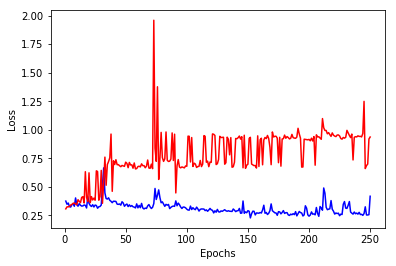

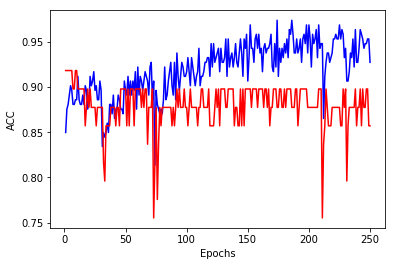

In [20]:
fitModel(250,10)
plot()

### Results

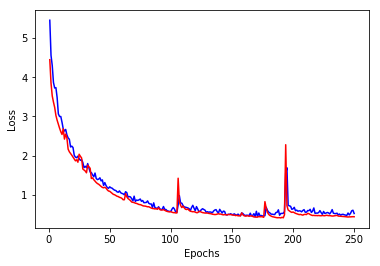

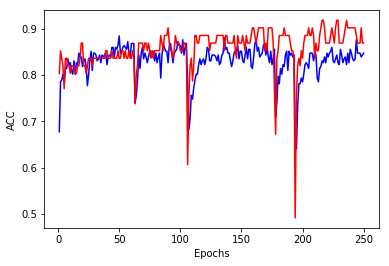

final evaluation of a model

In [21]:
model.evaluate(test_data.values, test_labels.values)

61/61 [==============================] - 0s 180us/sample - loss: 1.1386 - acc: 0.7869


[1.1385995110527414, 0.78688526]